# Learning Algorithms

```{contents}
```

## Where the data at

In [1]:
import pandas as pd
import sys
sys.path.append('../')
# from source.pacmap_functions import *

mount = '/mnt/h/'
input_path = mount + 'MethylScore/Intermediate_Files/'
output_path = mount + 'MethylScore/Processed_Data/'

## Load data

In [2]:
# read df_discovery and df_validation
df_discovery = pd.read_pickle(
    input_path+'3308samples_333059cpgs_withbatchcorrection_bvalues.pkl').sort_index()

df_validation = pd.read_pickle(
    input_path+'201samples_357839cpgs_withbatchcorrection_bvalues.pkl').sort_index()

# use overlapping features between df_discovery and df_validation
common_features = [x for x in df_discovery.columns if x in df_validation.columns]

# apply `common_features` to both df_discovery and df_validation
df_discovery = df_discovery[common_features]
df_validation = df_validation[common_features]

print(
f' Discovery dataset (df_discovery) contains {df_discovery.shape[1]} \
columns (5mC nucleotides/probes) and {df_discovery.shape[0]} rows (samples).')

print(
f' Validation dataset (df_validation) contains {df_validation.shape[1]} \
columns (5mC nucleotides/probes) and {df_validation.shape[0]} rows (samples).')

 Discovery dataset (df_discovery) contains 319558 columns (5mC nucleotides/probes) and 3308 rows (samples).
 Validation dataset (df_validation) contains 319558 columns (5mC nucleotides/probes) and 201 rows (samples).


## Reduce dimensionality with PaCMAP

### Set hyperparameters, fit, and save

In [3]:
import pacmap
print('PaCMAP version:', pacmap.__version__)

# components_list = [2, 5]
# for components in components_list:

#     # Initialize the instance
#     reducer = pacmap.PaCMAP(n_components=components, n_neighbors=15, MN_ratio=0.4, FP_ratio=16.0, 
#                             random_state=42, lr=0.1, num_iters=5000, save_tree=True)

#     # Project the high dimensional dataset into a low-dimensional embedding
#     embedding_training = reducer.fit(df_discovery.to_numpy(dtype='float16'))

#     # Save reducer
#     pacmap.save(reducer, f'../models/pacmap_{components}d_model_al_atlas')


PaCMAP version: 0.7.1


### Apply models to new data

In [26]:

def apply_pacmap_model_to_new_data(df, components):

    # Load reducer
    reducer = pacmap.load(f'../models/pacmap_{components}d_model_al_atlas')

    # Project the high dimensional dataset into existing embedding space and return the embedding.
    embedding = reducer.transform(df.to_numpy(dtype='float16'))

    # Create column names
    cols = ['PaCMAP '+ str(i+1) + f' of {components}' for i in range(components)]

    # Turn embedding into dataframe
    df_embedding = pd.DataFrame(embedding, columns=cols, index=df.index)

    return df_embedding


# Apply pacmap model to discovery dataset
train_2d = apply_pacmap_model_to_new_data(df_discovery, components=2)
train_5d = apply_pacmap_model_to_new_data(df_discovery, components=5)

# # Apply pacmap model to validation dataset
test_2d = apply_pacmap_model_to_new_data(df_validation, components=2)
test_5d = apply_pacmap_model_to_new_data(df_validation, components=5)

# Overall time: 42.8s 

/home/fmarchi/projects/AML-atlas-notebooks/.venv/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/fmarchi/projects/AML-atlas-notebooks/.venv/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/fmarchi/projects/AML-atlas-notebooks/.venv/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle

### Merge results with clinical data

In [28]:
# Join 2d and 5d
train = train_2d.join(train_5d)
test = test_2d.join(test_5d)

# Concatenate train and test
train_test = pd.concat([train, test])

# Read clinical data
clinical_data = pd.read_excel(input_path+'clinical_data.xlsx', index_col=0)

# Join train_test with clinical data
df = train_test.join(clinical_data)

## Preprocess data for classifiers

### Select samples Px

In [36]:

# Drop the samples with missing labels for the selected column
df_px = df[~df['Vital Status'].isna()]

df_px2 = df_px.copy()

# # Exclude the `Blood Derived Normal`and `Bone Marrow Normal` from `Sample Type`
# df_px2 = df_px[~df_px['Sample Type'].isin(['Relapse', 'Recurrent Blood Derived Cancer - Bone Marrow',
#                                             'Recurrent Blood Derived Cancer - Peripheral Blood',
#                                             'Blood Derived Normal', 'Bone Marrow Normal'])]

# print the number of samples dropped and the amount remaining
print(df.shape[0]-df_px2.shape[0], 'samples removed.'\
, df_px2.shape[0], 'samples remaining.')

1699 samples removed. 1810 samples remaining.


### Select samples Dx

In [38]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df_dx = df[~df['WHO 2022 Diagnosis'].isna()]

# exclude the classes with fewer than 10 samples
df_dx2 = df_dx[~df_dx['WHO 2022 Diagnosis'].isin([
                                       'MPAL with t(v;11q23.3)/KMT2A-r',
                                       'B-ALL with hypodiploidy',
                                       'AML with t(16;21); FUS::ERG',
                                       'AML with t(9;22); BCR::ABL1'
                                       ])]

# print the number of samples dropped and the amount remaining
print(df.shape[0]-df_dx2.shape[0], 'samples removed.'\
, df_dx2.shape[0], 'samples remaining.')

971 samples removed. 2538 samples remaining.


### Define X and y

In [39]:
def custom_train_test_split(df, feature_columns, target_column, split_column):

    X = df[feature_columns].to_numpy()
    y = df[target_column].to_numpy()

    train_mask = df[split_column] == 'Train Sample'
    test_mask = df[split_column] == 'Test Sample'

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)

    return X_train, X_test, y_train, y_test

# Execution
X_train_dx, X_test_dx, y_train_dx, y_test_dx = custom_train_test_split(df_dx2, test_5d.columns,'WHO 2022 Diagnosis', 'Train-Test')
X_train_px, X_test_px, y_train_px, y_test_px = custom_train_test_split(df_px2, test_5d.columns,'Vital Status', 'Train-Test')


X_train shape: (2436, 5) X_test shape: (102, 5)
X_train shape: (1609, 5) X_test shape: (201, 5)


## Benchmark classifiers

### Define confusion matrix plot function

In [40]:
def plot_confusion_matrix_stacked(clf, x_train, y_train, x_test, y_test, 
                                  title='', 
                                  tick_fontsize=10, label_fontsize=10,
                                  figsize=(10, 5)):

    sns.set_theme(style='white')

    fig, axs = plt.subplots(1, 2, figsize=figsize, sharey=True)

    fig.subplots_adjust(wspace=0.05)  # Adjust the width space

    for i, (ax, x, y, subset) in enumerate(zip(axs, [x_train, x_test], [y_train, y_test],
                                                ['Train with 10-fold CV', 'Validation'])):
        predictions = clf.predict(x)
        print(f'Overall accuracy score in {subset}: {accuracy_score(y, predictions):.3f}')
        cm = confusion_matrix(y, predictions, labels=clf.classes_, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical', colorbar=False, ax=ax)
    

        # Set font size of the numbers inside the confusion matrix
        for texts in disp.text_:
            for text in texts:
                text.set_fontsize(label_fontsize)

        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        ax.set_title(subset + ', n=' + str(len(x)), fontsize=label_fontsize+1, pad=10)
        ax.set_xlabel('Predicted label', fontsize=label_fontsize+1)

        # Add y labels
        if i == 0:
            ax.set_ylabel('True label', fontsize=label_fontsize+1)
        else:
            ax.set_ylabel('')

        # remove x tick labels
        ax.xaxis.set_ticklabels([])
        
    plt.show()

### Execute 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 2192, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Start training from score -4.434473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 2192, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

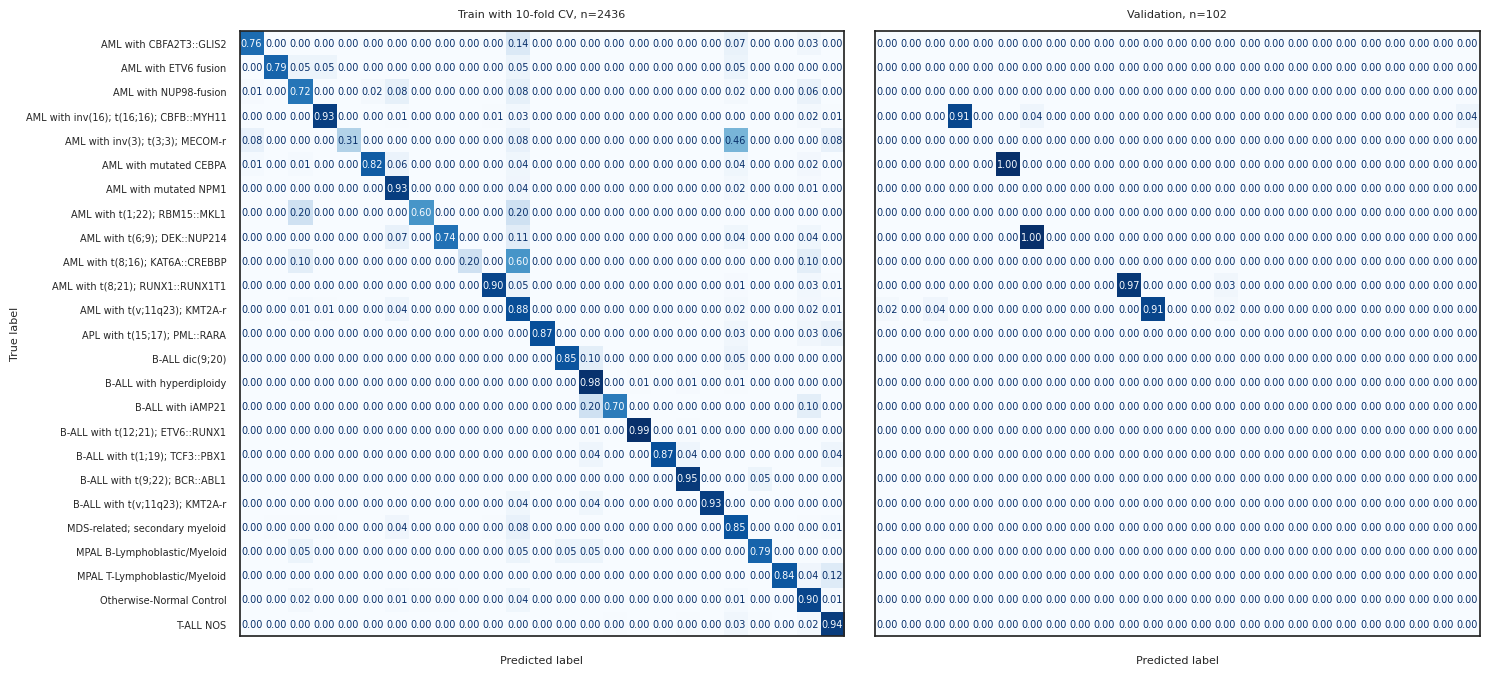

[LightGBM] [Info] Number of positive: 609, number of negative: 839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1448, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420580 -> initscore=-0.320392
[LightGBM] [Info] Start training from score -0.320392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 609, number of negative: 839
[LightGBM] [Info] Number of positive: 609, number of negative: 839
[LightGBM] [Info] Number of positive: 609, number of negative: 839
[LightGBM] 

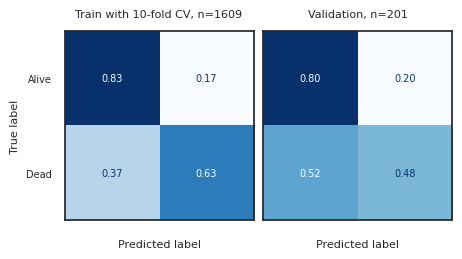

['../models/lgbm_dx_model.pkl']

In [42]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


def benchmark_classifier(X_train, y_train, X_test, y_test, figsize=(16,8)):

    # param_grid = {
    # 'num_leaves': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20], # number of leaves in full tree
    # 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # maximum depth of a tree
    # # 'learning_rate': [0.001, 0.01, 0.015, 0.02, 0.1],  # learning rate
    # # 'n_estimators': [10, 50, 100, 200],  # number of trees (or rounds)
    # }

    param_grid = {
    'num_leaves': [8], # number of leaves in full tree
    'max_depth': [4],  # maximum depth of a tree
    # 'learning_rate': [0.001, 0.01, 0.015, 0.02, 0.1],  # learning rate
    }
    # Initialize the LGBM Classifier with regularization
    lgbm = LGBMClassifier(random_state=42, n_jobs=-1, reg_alpha=1.0, reg_lambda=1.0)

    # Perform grid search with stratified cross-validation
    grid_search = GridSearchCV(lgbm, param_grid, cv=10, n_jobs=-1,
                               scoring='roc_auc_ovr_weighted',verbose=0)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")

    # Get the best model
    clf = grid_search.best_estimator_

    plot = plot_confusion_matrix_stacked(clf, X_train, y_train, X_test, y_test,
                                  tick_fontsize=7, label_fontsize=7, figsize=figsize)
    return clf, plot

    # Plot the confusion matrix

# Benchmark, train
lgbm_dx_model, plot = benchmark_classifier(X_train_dx, y_train_dx, X_test_dx, y_test_dx)
lgbm_px_model, plot = benchmark_classifier(X_train_px, y_train_px, X_test_px, y_test_px,
                                           figsize=(5,3))

# Save models
joblib.dump(lgbm_px_model,'../models/lgbm_px_model.pkl')
joblib.dump(lgbm_dx_model,'../models/lgbm_dx_model.pkl')

# 16m 25.7s


## Save results

In [63]:
def save_predictions(df, classifier, model_name):

    # ignore sklearn warnings
    import warnings
    warnings.filterwarnings('ignore')

    # Select necessary columns
    df_features = df[test_5d.columns]

    # Predict using the selected columns
    predictions = classifier.predict(df_features)

    # Predict probabilities using the selected columns
    probabilities = classifier.predict_proba(df_features)

    # Convert predictions to a Series with the same index as df_features
    predictions_series = pd.Series(predictions, index=df_features.index, name=model_name)

    # Convert probabilities to a DataFrame with the same index as df_features and the same columns as the classes
    probabilities_df = pd.DataFrame(probabilities, index=df_features.index, columns=classifier.classes_).round(3)

    # Add " - predict_proba" to the column names
    probabilities_df.columns ='P(' + probabilities_df.columns + ')'

    # # Create a new column named "Confidence" and set it to True if the max probability is >= confidence_threshold
    # probabilities_df['Confidence >=' + str(confidence_threshold)] = probabilities_df.max(axis=1) >= confidence_threshold

    # Transform classes of the predictions into integers based on unique values in the classes
    probabilities_df[model_name + '_int'] = predictions_series.map({c: i for i, c in enumerate(classifier.classes_)})

    # Join predictions with the original DataFrame (already indexed)
    df_joined = predictions_series.to_frame().join(probabilities_df)

    return df_joined

# Execution
df_pred_px = save_predictions(df=df, classifier=lgbm_px_model, model_name='AML Epigenomic Risk')
df_pred_dx = save_predictions(df=df, classifier=lgbm_dx_model, model_name='AL Epigenomic Phenotype')

# Map the classes to the desired labels
df_pred_px['AML Epigenomic Risk'] = df_pred_px['AML Epigenomic Risk'].map({'Alive': 'Low', 'Dead': 'High'})

# Join predictions with clinical data
df_combined = df.join(df_pred_px).join(df_pred_dx)

# Save df_combined
df_combined.to_excel('../data/al_atlas_main_results.xlsx')

## Other benchmarked classifiers

### Gaussian Process Classifier

In [64]:
# from sklearn.gaussian_process import GaussianProcessClassifier

# # Define the parameter grid
# param_grid = {
#     'multi_class': ['one_vs_rest'], 
# }

# # Initialize the Gaussian Process Classifier
# gpc = GaussianProcessClassifier(random_state=42, n_jobs=-1)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(gpc, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
# grid_search.fit(X_train, y_train)

# # Fit and predict using the best estimator
# gpc_px_model = grid_search.best_estimator_

# y_pred = gpc_px_model.predict(X_test)  # Predict using the best model

# # Print the best parameters and the best score
# print(f"Best parameters: {grid_search.best_params_}")

# # Fit and predict using the best estimator
# gpc_px_model = grid_search.best_estimator_

# y_pred_train = gpc_px_model.predict(X_train)  # Predict using the best model
# y_pred_test = gpc_px_model.predict(X_test)  # Predict using the best model


# print(f'Overall accuracy score with best estimator in train: {accuracy_score(y_train, y_pred_train):.3f}')
# print(f'Overall accuracy score with best estimator in test: {accuracy_score(y_test, y_pred_test):.3f}')

# # plot the confusion matrix
# plot_confusion_matrix_stacked(gpc_px_model, X_train, y_train, X_test, y_test,
#                               tick_fontsize=7, label_fontsize=7, figsize = (5,3))

# # you shall save the model
# pickle.dump(gpc_px_model, open('../models/gpc_px_model.pkl', 'wb'))


## Watermark

In [66]:
%load_ext watermark

In [67]:
# watermark with all libraries used in this notebook
%watermark -v -p numpy,pandas,pacmap,sklearn -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.3

numpy  : 1.24.4
pandas : 2.0.3
pacmap : 0.7.1
sklearn: 1.3.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 6
Architecture: 64bit

